### Desenvolvimento do modelo de Machine Learning.
Versão 3.0 (XGboost)

`1. Engenharia de Features (Melhorar os Dados):`

* Vou criar uma feature que o modelo não tem: a relação entre valor e tempo. Clientes que pagam muito e estão há pouco tempo são mais arriscados?

`2. Migração do algoritmo:`

* Migração do algoritmo de Regressão Logística (linear) para o XGBoost (Gradient Boosting). Ele é capaz de capturar padrões complexos e não-lineares que a Logística perde.

`3. Ajuste de Threshold:`

* Em vez de aceitar o padrão de 50% de probabilidade, vou perguntar ao computador: "Qual é a porcentagem de certeza exata que me dá mais dinheiro?"

In [17]:
# Importe das Bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score, roc_auc_score, confusion_matrix


In [ ]:
# PREPARAÇÃO DOS DADOS (Recarregando os dados)
df = pd.read_csv(r'C:\Users\proje\OneDrive\Ambiente de Trabalho\Projetos_2025\projeto_EDA+ML\dados\WA_Fn-UseC_-Telco-Customer-Churn.csv')
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce').fillna(0)
df = df.drop(columns=['customerID'])
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0}) 

In [ ]:
# ---ETAPA 1: FEATURE ENGINEERING (Criação de Variação) ---

# Ideia: Clientes com contrato mensal E fibra ótica costumam sair mais. Vou explicitar isso.
# (Nota: Farei isso antes do get_dummies)
df['Interaction_Fiber_Month'] = df.apply(lambda x: 1 if x['InternetService'] == 'Fiber optic' and x['Contract'] == 'Month-to-month' else 0, axis=1)

# Encoding e Split
df_ml = pd.get_dummies(df, drop_first=True)
X = df_ml.drop('Churn', axis=1)
y = df_ml['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [20]:
# --- TEMA 2: ALGORITMO XGBOOST COM VALIDAÇÃO ---

ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)
print(f"Treinando XGBoost com scale_pos_weight = {ratio:.2f}")

# Configuração do Modelo
model_xgb = XGBClassifier(
    n_estimators=200,            # Mais árvores para compensar o learning rate baixo
    learning_rate=0.05,          # Aprendizado suave
    max_depth=4,                 # Profundidade controlada
    scale_pos_weight=ratio,      # Foco no Recall (Balanceamento)
    subsample=0.8,               # 80% das linhas por árvore (Regularização)
    colsample_bytree=0.8,        # 80% das colunas por árvore (Regularização)
    random_state=42,
    eval_metric='logloss',       # Métrica de avaliação correta
    verbosity=0,                 # Silencioso
    early_stopping_rounds=10     # Para de treinar se não melhorar em 10 rodadas
)

# Treinamento com validação (Early Stopping precisa do eval_set)
# O modelo vai olhar para o X_test para saber quando parar
model_xgb.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)], 
    verbose=False
)

# Previsões (Probabilidades)
y_proba = model_xgb.predict_proba(X_test)[:, 1]

print(f"Melhor iteração: {model_xgb.best_iteration}")

Treinando XGBoost com scale_pos_weight = 2.77
Melhor iteração: 100


In [ ]:
# --- ETAPA 3: OTIMIZAÇÃO DE THRESHOLD (Busca pelo Lucro Máximo) ---

# Vou testar cortes de 0% a 100% e ver qual dá mais dinheiro
thresholds = np.arange(0, 1.01, 0.01)
lucros = []
ticket_medio = 65.00
custo_retencao = 10.00
taxa_sucesso = 0.5

melhor_lucro = -float('inf')
melhor_thresh = 0.5

for t in thresholds:
    # Cria a previsão baseada no threshold atual 't'
    y_pred_temp = (y_proba >= t).astype(int)
    
    # Pega a matriz de confusão
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_temp).ravel()
    
    # Calcula o lucro
    custo = (tp + fp) * custo_retencao
    receita = (tp * taxa_sucesso) * ticket_medio
    lucro = receita - custo
    lucros.append(lucro)
    
    if lucro > melhor_lucro:
        melhor_lucro = lucro
        melhor_thresh = t

----------------------------------------
THRESHOLD ENCONTRADO: 0.52 (Probabilidade)
LUCRO MÁXIMO PROJETADO:      R$ 4,065.00
----------------------------------------
Recall Final:    0.79
Precision Final: 0.54


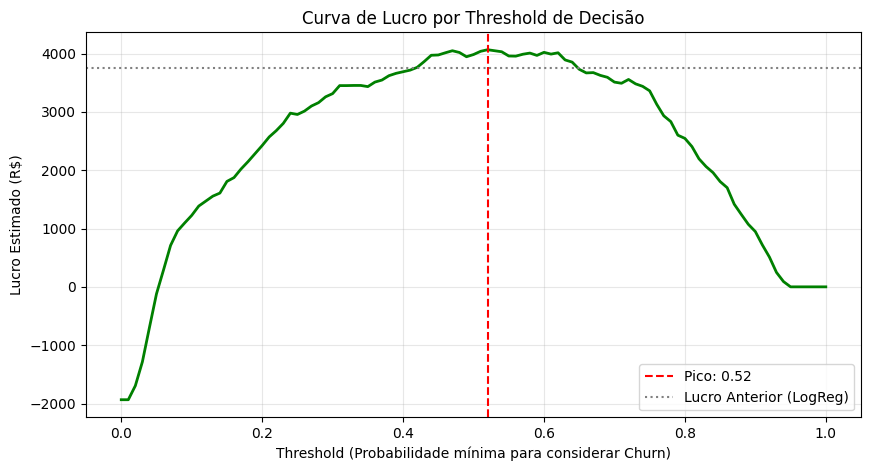

In [ ]:
# --- RESULTADOS FINAIS ---

print("-" * 40)
print(f"THRESHOLD ENCONTRADO: {melhor_thresh:.2f} (Probabilidade)")
print(f"LUCRO MÁXIMO PROJETADO:      R$ {melhor_lucro:,.2f}")
print("-" * 40)

# Aplicando o threshold para ver as métricas finais
y_pred_final = (y_proba >= melhor_thresh).astype(int)
print(f"Recall Final:    {recall_score(y_test, y_pred_final):.2f}")
print(f"Precision Final: {precision_score(y_test, y_pred_final):.2f}")

# Gráfico da Curva de Lucro
plt.figure(figsize=(10, 5))
plt.plot(thresholds, lucros, color='green', linewidth=2)
plt.axvline(melhor_thresh, color='red', linestyle='--', label=f'Pico: {melhor_thresh}')
plt.axhline(3755, color='gray', linestyle=':', label='Lucro Anterior (LogReg)') # Linha de referência do modelo anterior
plt.title('Curva de Lucro por Threshold de Decisão')
plt.xlabel('Threshold (Probabilidade mínima para considerar Churn)')
plt.ylabel('Lucro Estimado (R$)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# Exportando o modelo
import joblib

# 1. Salva o Modelo Treinado
joblib.dump(model_xgb, 'modelo_xgboost.pkl')

# 2. Salva os nomes das colunas usada no treino
# Isso é CRUCIAL. O app precisa criar um DataFrame com as mesmas colunas, na mesma ordem.
joblib.dump(X_train.columns, 'feature_modelo_pkl')

print("Arquivo --> 'modelo_xgboost.pkl' salvo com sucesso! ✅")
print("Arquivo --> 'feature_modelo.pkl' salvo com sucesso! ✅")

Arquivo --> 'modelo_xgboost.pkl' salvo com sucesso! ✅
Arquivo --> 'features_modelo.pkl' salvo com sucesso! ✅
